# Breast cancer best_knn

In [33]:
!pip install ucimlrepo


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [34]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import numpy as np
from scipy.interpolate import interp1d

from sklearn.model_selection import KFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    recall_score,
    classification_report,
    roc_auc_score,
    auc,
    roc_curve,
    RocCurveDisplay,
    ConfusionMatrixDisplay
)

## Dataset

In [35]:
breast_cancer_wisconsin_original = fetch_ucirepo(id=15)
breast_cancer_wisconsin_original.metadata

{'uci_id': 15,
 'name': 'Breast Cancer Wisconsin (Original)',
 'repository_url': 'https://archive.ics.uci.edu/dataset/15/breast+cancer+wisconsin+original',
 'data_url': 'https://archive.ics.uci.edu/static/public/15/data.csv',
 'abstract': 'Original Wisconsin Breast Cancer Database',
 'area': 'Health and Medicine',
 'tasks': ['Classification'],
 'characteristics': ['Multivariate'],
 'num_instances': 699,
 'num_features': 9,
 'feature_types': ['Integer'],
 'demographics': [],
 'target_col': ['Class'],
 'index_col': ['Sample_code_number'],
 'has_missing_values': 'yes',
 'missing_values_symbol': 'NaN',
 'year_of_dataset_creation': 1990,
 'last_updated': 'Sun Mar 10 2024',
 'dataset_doi': '10.24432/C5HP4Z',
 'creators': ['WIlliam Wolberg'],
 'intro_paper': None,
 'additional_info': {'summary': "Samples arrive periodically as Dr. Wolberg reports his clinical cases. The database therefore reflects this chronological grouping of the data. This grouping information appears immediately below, ha

In [36]:
breast_cancer_wisconsin_original.variables

,name,role,type,demographic,description,units,missing_values
0,Sample_code_number,ID,Categorical,None,None,None,no
1,Clump_thickness,Feature,Integer,None,None,None,no
2,Uniformity_of_cell_size,Feature,Integer,None,None,None,no
3,Uniformity_of_cell_shape,Feature,Integer,None,None,None,no
4,Marginal_adhesion,Feature,Integer,None,None,None,no
5,Single_epithelial_cell_size,Feature,Integer,None,None,None,no
6,Bare_nuclei,Feature,Integer,None,None,None,yes
7,Bland_chromatin,Feature,Integer,None,None,None,no
8,Normal_nucleoli,Feature,Integer,None,None,None,no
9,Mitoses,Feature,Integer,None,None,None,no


In [37]:
# Data (as pandas dataframes)
X = breast_cancer_wisconsin_original.data.features
y = breast_cancer_wisconsin_original.data.targets

X.tail()

,Clump_thickness,Uniformity_of_cell_size,Uniformity_of_cell_shape,Marginal_adhesion,Single_epithelial_cell_size,Bare_nuclei,Bland_chromatin,Normal_nucleoli,Mitoses
694,3,1,1,1,3,2.0,1,1,1
695,2,1,1,1,2,1.0,1,1,1
696,5,10,10,3,7,3.0,8,10,2
697,4,8,6,4,3,4.0,10,6,1
698,4,8,8,5,4,5.0,10,4,1


In [38]:
y.tail()

,Class
694,2
695,2
696,4
697,4
698,4


### Explicação das Colunas do Dataset

O dataset contém características extraídas de imagens digitalizadas de biópsias de mama. Cada linha representa uma amostra e cada coluna representa uma característica analisada microscopicamente. As explicações de cada coluna são:

1. **Espessura_do_aglomerado (Clump_thickness):**
   - Mede a espessura dos aglomerados celulares. Valores maiores podem indicar a presença de células cancerígenas, que geralmente se agrupam de forma densa.

2. **Uniformidade_tamanho_celular (Uniformity_of_cell_size):**
   - Avalia a consistência do tamanho das células. Maior variabilidade pode indicar malignidade.

3. **Uniformidade_forma_celular (Uniformity_of_cell_shape):**
   - Analisa a uniformidade das formas celulares. Células cancerígenas apresentam formas mais irregulares.

4. **Adesao_marginal (Marginal_adhesion):**
   - Mede a força de adesão entre células. Células normais aderem melhor umas às outras do que as malignas.

5. **Tamanho_celular_epitelial_unica (Single_epithelial_cell_size):**
   - Avalia o tamanho de células epiteliais individuais. Células maiores podem estar associadas a câncer.

6. **Nucleos_nus (Bare_nuclei):**
   - Contagem de núcleos sem citoplasma visível. Este é um indicador importante de malignidade.

7. **Cromatina_suave (Bland_chromatin):**
   - Mede a textura da cromatina (material genético no núcleo). A textura suave é típica de células normais.

8. **Nucleolos_normais (Normal_nucleoli):**
   - Quantifica o número de nucléolos (estruturas no núcleo). Números elevados podem estar associados a câncer.

9. **Mitose (Mitoses):**
   - Mede a taxa de divisão celular. Taxas altas são um indicador claro de malignidade.

10. **Classe_Binaria:**
    - Classe alvo do problema, representando:
      - `0`: Tumor benigno.
      - `1`: Tumor maligno.


### Distribuição do dataset

In [39]:
# Combinar X e y em um único DataFrame
full_dataset = X.copy()  # Criar uma cópia do DataFrame X
full_dataset['Class'] = y  # Adicionar a coluna 'Class' de y

full_dataset.describe().round(3).T

,count,mean,std,min,25%,50%,75%,max
Clump_thickness,699.0,4.418,2.816,1.0,2.0,4.0,6.0,10.0
Uniformity_of_cell_size,699.0,3.134,3.051,1.0,1.0,1.0,5.0,10.0
Uniformity_of_cell_shape,699.0,3.207,2.972,1.0,1.0,1.0,5.0,10.0
Marginal_adhesion,699.0,2.807,2.855,1.0,1.0,1.0,4.0,10.0
Single_epithelial_cell_size,699.0,3.216,2.214,1.0,2.0,2.0,4.0,10.0
Bare_nuclei,683.0,3.545,3.644,1.0,1.0,1.0,6.0,10.0
Bland_chromatin,699.0,3.438,2.438,1.0,2.0,3.0,5.0,10.0
Normal_nucleoli,699.0,2.867,3.054,1.0,1.0,1.0,4.0,10.0
Mitoses,699.0,1.589,1.715,1.0,1.0,1.0,1.0,10.0
Class,699.0,2.690,0.951,2.0,2.0,2.0,4.0,4.0


O dataset aparenta estar bem distribuido

In [40]:
class_counts = y.value_counts()
class_counts

Class
2        458
4        241
Name: count, dtype: int64

Já que temos apenas 2 classes, vamos transforma-la em binária.

In [41]:
y = y.replace({2: 0, 4: 1})
class_counts = y.value_counts()
class_counts

Class
0        458
1        241
Name: count, dtype: int64

In [42]:
full_dataset['Class'] = y

### Valores nulos:

In [43]:
X.isna().sum()

Clump_thickness                 0
Uniformity_of_cell_size         0
Uniformity_of_cell_shape        0
Marginal_adhesion               0
Single_epithelial_cell_size     0
Bare_nuclei                    16
Bland_chromatin                 0
Normal_nucleoli                 0
Mitoses                         0
dtype: int64

Since we have 16 missing values on Bare_nuclei, we will handle that.

In [44]:
X[X['Bare_nuclei'].isna()]

,Clump_thickness,Uniformity_of_cell_size,Uniformity_of_cell_shape,Marginal_adhesion,Single_epithelial_cell_size,Bare_nuclei,Bland_chromatin,Normal_nucleoli,Mitoses
23,8,4,5,1,2,NaN,7,3,1
40,6,6,6,9,6,NaN,7,8,1
139,1,1,1,1,1,NaN,2,1,1
145,1,1,3,1,2,NaN,2,1,1
158,1,1,2,1,3,NaN,1,1,1
164,5,1,1,1,2,NaN,3,1,1
235,3,1,4,1,2,NaN,3,1,1
249,3,1,1,1,2,NaN,3,1,1
275,3,1,3,1,2,NaN,2,1,1
292,8,8,8,1,2,NaN,6,10,1


In [45]:
# Fill missing values in 'Bare_nuclei' with the most frequent value
most_frequent_value = X['Bare_nuclei'].mode()[0]
X.loc[:, 'Bare_nuclei'] = X['Bare_nuclei'].fillna(most_frequent_value)

# Verify if there are any more missing values
X.isna().sum()

Clump_thickness                0
Uniformity_of_cell_size        0
Uniformity_of_cell_shape       0
Marginal_adhesion              0
Single_epithelial_cell_size    0
Bare_nuclei                    0
Bland_chromatin                0
Normal_nucleoli                0
Mitoses                        0
dtype: int64

In [46]:
duplicate_rows = full_dataset[full_dataset.duplicated()]

if not duplicate_rows.empty:
    print("Linhas duplicadas:")
    print(duplicate_rows)
else:
    print("Nenhuma linha duplicada foi achada.")

Linhas duplicadas:
     Clump_thickness  Uniformity_of_cell_size  Uniformity_of_cell_shape  \
28                 2                        1                         1   
35                 2                        1                         1   
48                 4                        1                         1   
64                 1                        1                         1   
66                 4                        1                         1   
..               ...                      ...                       ...   
686                1                        1                         1   
688                4                        1                         1   
690                1                        1                         1   
692                3                        1                         1   
695                2                        1                         1   

     Marginal_adhesion  Single_epithelial_cell_size  Bare_nuclei  \
28          

In [47]:
# X = X.drop_duplicates()
# duplicated_rows_after_removal = X[X.duplicated()]

# if not duplicated_rows_after_removal.empty:
#     print("Linhas duplicadas:")
#     print(duplicated_rows_after_removal)
# print("Linhas duplicadas removidas.")

## Visualizações dos dados

In [48]:
# Palete de cores personalizadas para 'não benigno' (cinza) e 'benigno 1' (vermelho)
custom_palette = {0: 'gray', 1: 'darkred'}

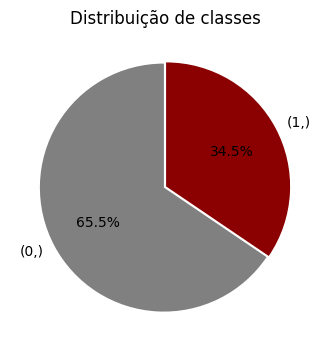

In [49]:
plt.figure(figsize=(4, 5))
class_counts.plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    colors=[custom_palette.get(0), custom_palette.get(1)],
    labels=class_counts.index,
    explode=(0.01, 0.01)  # Separando a primeira fatia
)

plt.title('Distribuição de classes')
plt.ylabel('')  # Remove o label do eixo Y
plt.show()

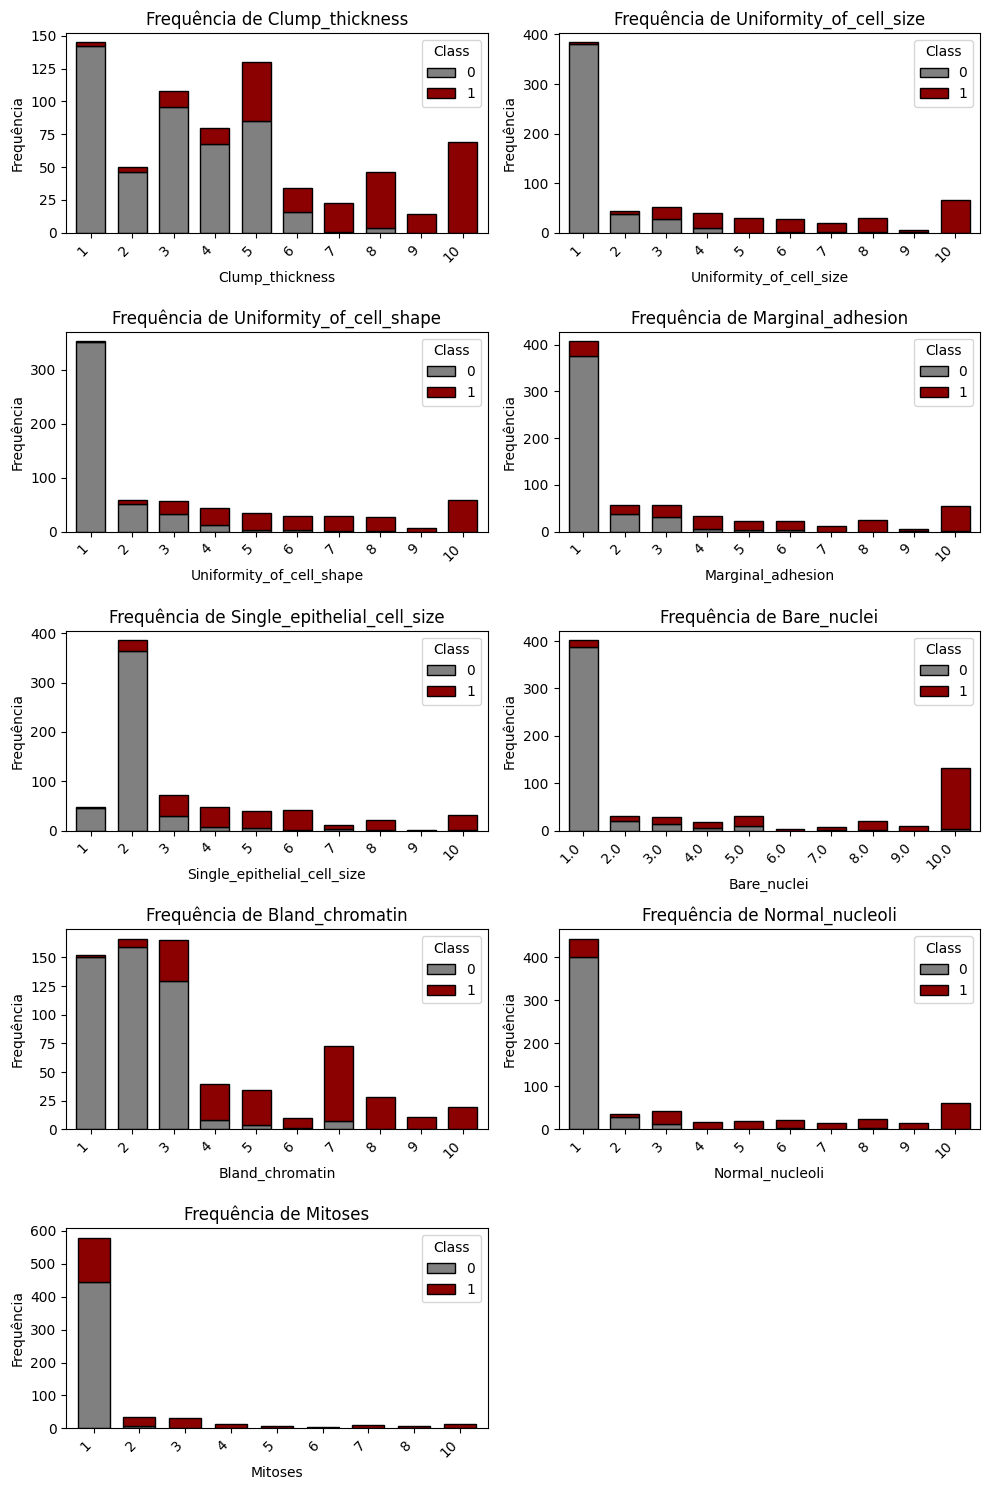

In [50]:
# Número de colunas e linhas para os subplots
num_columns = len(X.columns)
num_rows = (num_columns + 1) // 2

plt.figure(figsize=(10, 3 * num_rows))

# Plotar cada atributo em gráficos de barras empilhadas
for i, column in enumerate(X.columns, 1):
    plt.subplot(num_rows, 2, i)

    # Contagem das ocorrências de cada classe para cada valor da coluna
    count_data = full_dataset.groupby([column, 'Class']).size().unstack(fill_value=0)

    # Plotando barras empilhadas
    count_data.plot(kind='bar', stacked=True, color=custom_palette,
                    ax=plt.gca(), width=0.7, edgecolor='black')  # Ajuste de largura e contorno preto

    plt.title(f'Frequência de {column}')
    plt.xlabel(column)
    plt.ylabel('Frequência')
    plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()


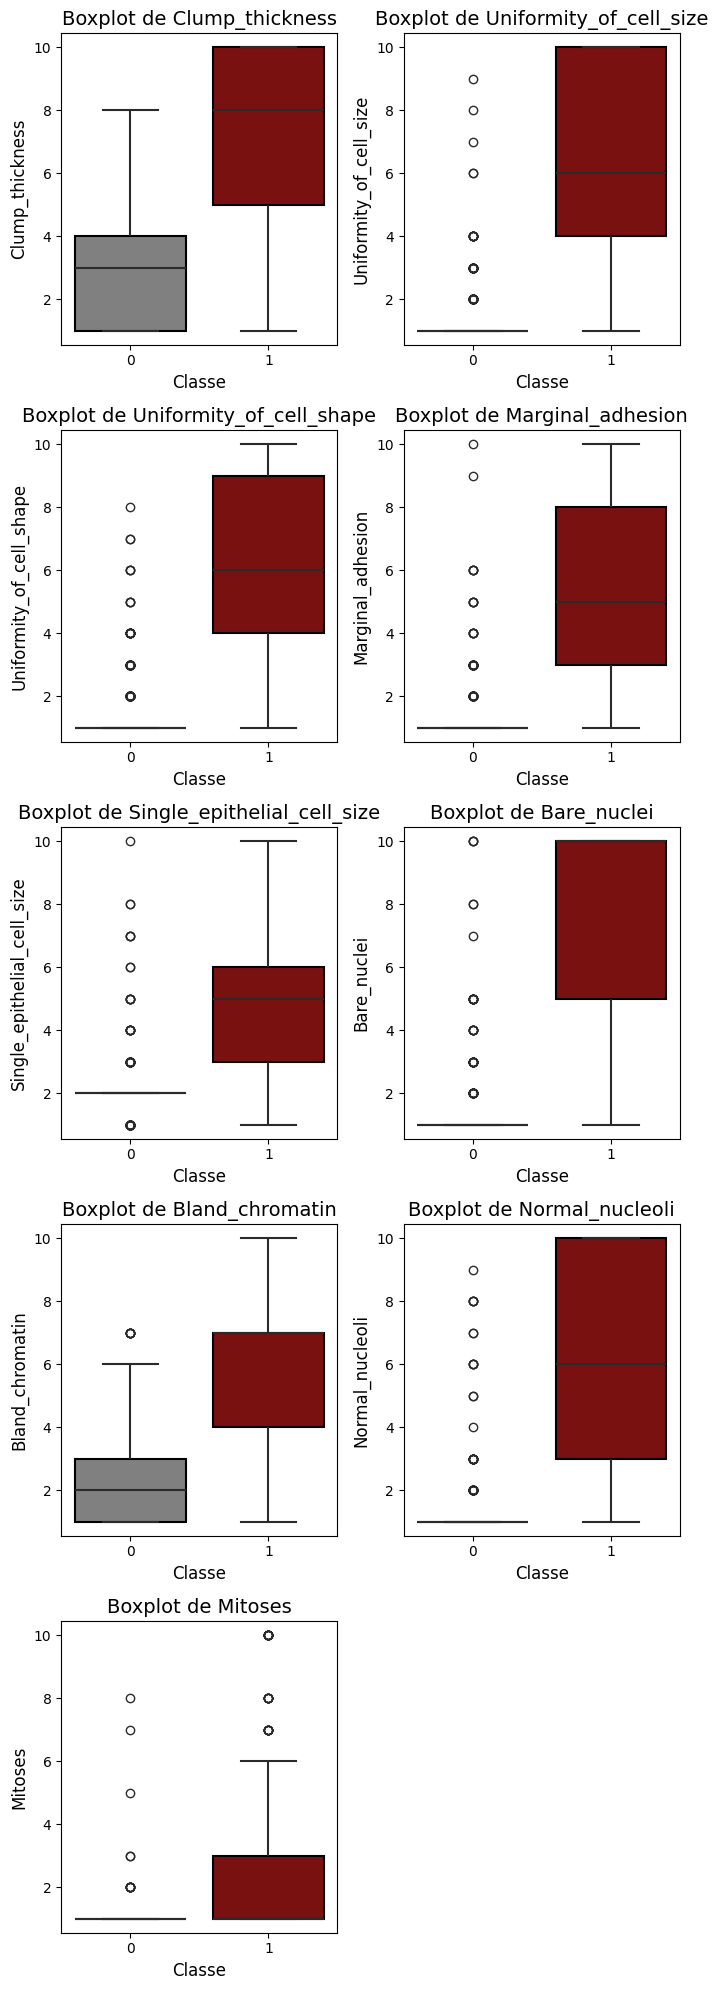

In [51]:
plt.figure(figsize=(7, 4 * num_rows))  # Aumentando o tamanho da figura para mais espaço

# Plotar Boxplot para cada atributo
for i, column in enumerate(X.columns, 1):
    plt.subplot(num_rows, 2, i)
    sns.boxplot(x='Class', y=column, data=full_dataset, hue='Class', palette=custom_palette,
                linewidth=1.5, fliersize=6, boxprops=dict(edgecolor="black"), legend=False)  # Contorno nas caixas e tamanho dos outliers

    plt.title(f'Boxplot de {column}', fontsize=14)
    plt.xlabel('Classe', fontsize=12)
    plt.ylabel(column, fontsize=12)

    # Rotacionar os rótulos do eixo X, se necessário
    plt.xticks(rotation=0)
    # Ajustar o espaçamento do eixo X (diminuir o espaçamento das barras)
    plt.subplots_adjust(bottom=0.15, hspace=0.4)

plt.tight_layout()
plt.show()


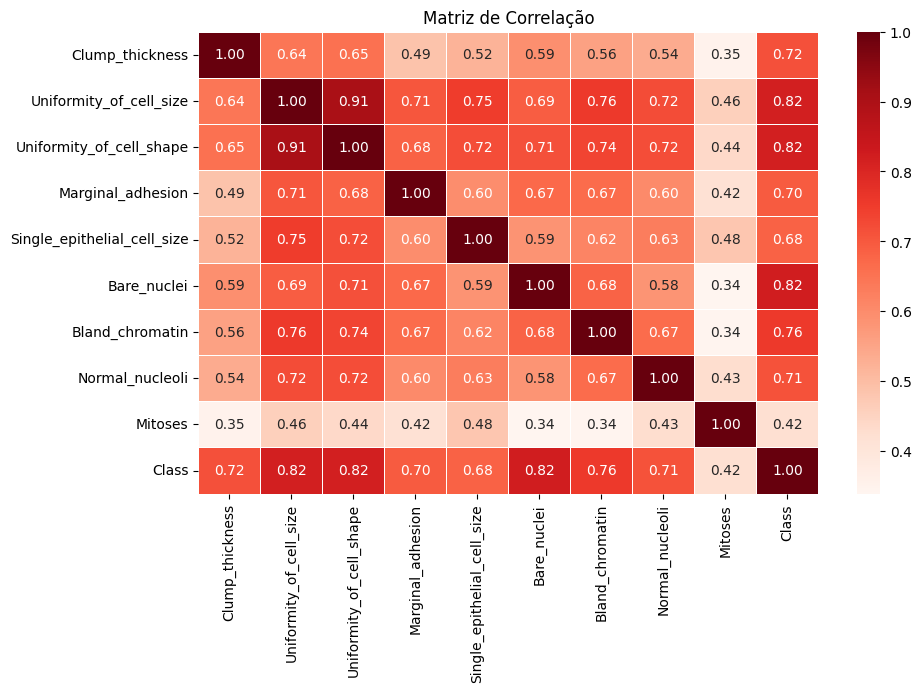

In [52]:
correlation_matrix = full_dataset.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='Reds', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlação')
plt.show()


## K-NN
O K-NN é um algoritmo de aprendizado supervisionado que normalmente é utilizado apra classificações e regressões, é um algoritmo que se baseia na ideia de dados, dispostos em um gráfico, serão semelhantes a medida de suas distâncias. Por se temos um gráfico que procura identificar se algo é uma laranja ou um limão baseado em seu tamanho e sua cor, é esperado que as laranjas estejam todas localizadas mais próximas do espectro laranja e de tamanhos "grandes", enquanto limões estarão próximos do tamanho "pequeno" e o espectro verde. Dessa forma uma fruta misteriosa que esteja entre o verde e o laranja e de um tamanho "médio" será melhor classificada se tomarmos o quão próximo ela está das laranjas ou dos limões.

É basicamente isso que fazemos com o algoritmo dos K-NN, utilizamos os K vizinhos de um determinado objeto para obter respostas sobre o mesmo.

Alguns aspectos **negativos** importantes do K-NN, o algoritmo é considerado "lento" dado grandes volumes de dados ou objetos com muitas características, afinal ele cálcula todas as distâncias a cada objeto novo adicionado, além disso ele guarda todas informações em memória, criando então um alto potencial de ser um algoritmo pesado.

Aspectos **postivos** seriam a simplicidade de implementação do algoritmo, sua flexibilidade, podendo ser aplicado a diferentes classes e também poder ser utilizado tanto para classificação como regressão e por último é um algoritmo que não precisa de hipótese forte, não precisando então supor nada sobre o conjunto de dados.


Importante notar que o caso explicitado acima foi um exemplo de classificação, mas também podemos ter uma regressão no caso de prever valores contínuos como o preço de uma casa dado seu tamanho, localização, número de quartos, etc.

Por último, alguns métodos de cálculo de distâncias podem ser utilizados, neste trabalho utilizamos o mais usual que é o euclidiano que ocorre quando $p=2$ na equação da distância de Minkowski:
$
d(p, q) = \left( \sum_{i=1}^{n} |p_i - q_i|^p \right)^{\frac{1}{p}}
$

## Treinamento

Vamos treinar com diferentes números de vizinhos com o objetivo de saber qual número ideal em que o modelo consegue ter uma boa performance e ser generalista. Além disso, ainda vamos utilizar da técnica de validação cruzada para avaliar a capacidade de generalização dos modelos.

O workflow de treinamento será equivalente ao recomendado em: https://scikit-learn.org/stable/modules/cross_validation.html.

<img src="https://scikit-learn.org/stable/_images/grid_search_workflow.png" alt="Model workflow" width="600">

Nosso KFold cross validation realizará as seguintes ações:

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" alt="Model workflow" width="600">

Dessa forma saberemos quais melhores parâmetros do modelo, no nosso caso, qual melhor quantidade de vizinhos k. Assim, poderemos retreinar o modelo nos dados de treino completos e utilizar dos dados de teste para avaliar métricas em dados nunca visto antes pela nossa máquina de aprendizado.

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)

# transformando para vetor de 1 dimensão para treinamento
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [54]:
# Normalizando os dados
scaler = StandardScaler()
scaler.fit_transform(X) # fitar no dataset inteiro
X_test = scaler.transform(X_test)
X_train = scaler.transform(X_train)

Foi escolhido avaliar o melhor modelo através da métrica de sensibilidade:

Sensibilidade ou revocação (Fração de tumores malignos corretamente identificados):
$$
\text{Revocação} = \frac{\text{VP}}{\text{VP} + \text{FN}}
$$

O motivo de tal escolha é que na área médica essa é uma medida muito utilizada e importante, pois é mais importante prever pacientes doentes, que diagnósticar como doente uma pessoa saudável.

Também analisaremos a performance sobre a curva ROC.

k = 1: Média ROC-AUC = 0.9476, Média Recall = 0.9231
k = 3: Média ROC-AUC = 0.9813, Média Recall = 0.9546
k = 5: Média ROC-AUC = 0.9897, Média Recall = 0.9546
k = 7: Média ROC-AUC = 0.9907, Média Recall = 0.9600
k = 9: Média ROC-AUC = 0.9923, Média Recall = 0.9550
k = 11: Média ROC-AUC = 0.9940, Média Recall = 0.9550
k = 13: Média ROC-AUC = 0.9937, Média Recall = 0.9507

Melhor modelo: k = 7 com Recall = 0.9600


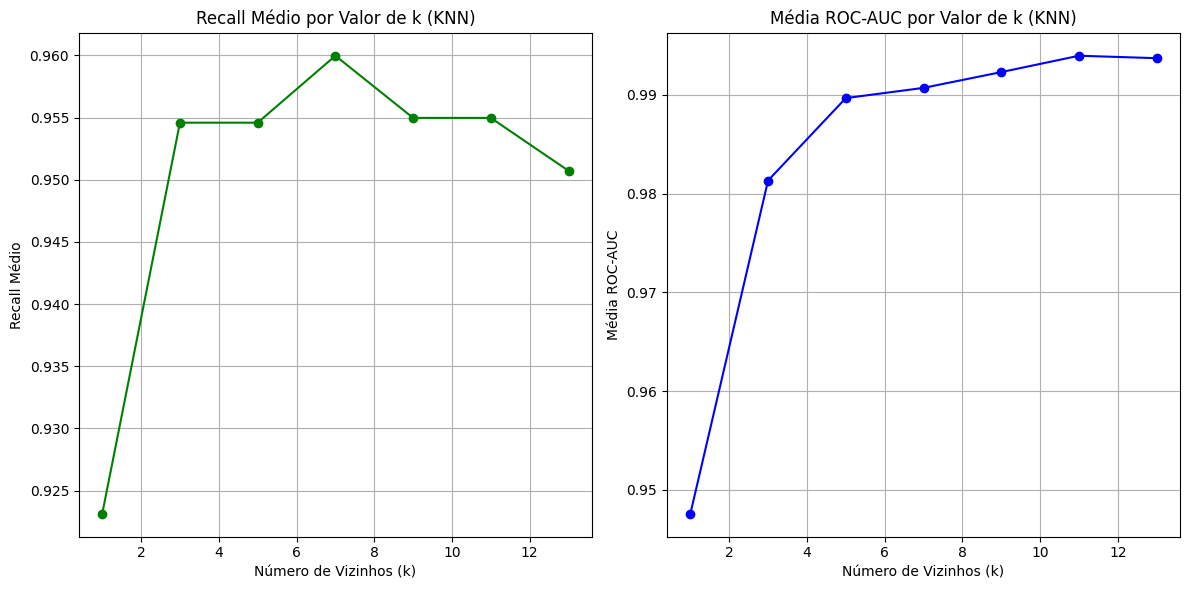

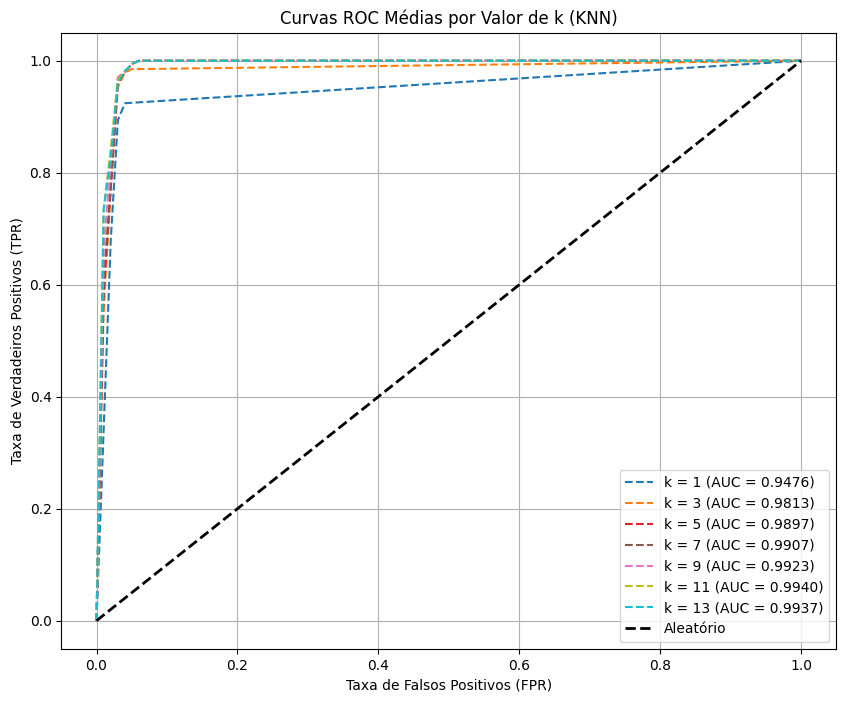

In [55]:
def train_kfold_knn_with_recall_and_auc(k_values, X, y, n_splits=5):
    best_k = None
    best_knn = None
    best_recall = 0
    models = []

    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    mean_auc_scores = []
    mean_recall_scores = []  # Para armazenar o recall médio de cada k

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
        auc_scores = []
        recall_scores = []  # Para armazenar o recall de cada fold
        tprs = []

        for train_index, val_index in kf.split(X):
            X_train_fold, X_val_fold = X[train_index], X[val_index]
            y_train_fold, y_val_fold = y[train_index], y[val_index]

            knn.fit(X_train_fold, y_train_fold)
            y_val_pred = knn.predict(X_val_fold)
            y_val_prob = knn.predict_proba(X_val_fold)[:, 1]

            # Calcular recall/sensibilidade para a classe "maligna" (1)
            recall = recall_score(y_val_fold, y_val_pred, pos_label=1)
            recall_scores.append(recall)

            # Calcular curva ROC e AUC
            fpr, tpr, _ = roc_curve(y_val_fold, y_val_prob)
            auc_value = auc(fpr, tpr)
            auc_scores.append(auc_value)

            # Interpolar TPR para FPR comum
            tpr_interpolated = np.interp(mean_fpr, fpr, tpr)
            tpr_interpolated[0] = 0.0
            tprs.append(tpr_interpolated)

        # Calcular AUC e recall médios para este k
        mean_auc = np.mean(auc_scores)
        mean_recall = np.mean(recall_scores)

        mean_auc_scores.append(mean_auc)
        mean_recall_scores.append(mean_recall)
        all_tpr.append(np.mean(tprs, axis=0))

        print(f"k = {k}: Média ROC-AUC = {mean_auc:.4f}, Média Recall = {mean_recall:.4f}")

        # Atualizar o melhor modelo baseado no recall
        if mean_recall > best_recall:
            best_recall = mean_recall
            best_knn = knn
            best_k = k

    return best_k, best_knn, best_recall, mean_auc_scores, mean_recall_scores, mean_fpr, all_tpr


# Treinar o modelo
k_values = [1, 3, 5, 7, 9, 11, 13] # escolhendo valores de k impáres para evitar empates
best_k, best_knn, best_recall, mean_auc_scores, mean_recall_scores, mean_fpr, all_tpr = train_kfold_knn_with_recall_and_auc(
    k_values, X_train, y_train
)

print(f"\nMelhor modelo: k = {best_k} com Recall = {best_recall:.4f}")

# Gráfico: Recall médio por valor de k
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # Subplot para Recall
plt.plot(k_values, mean_recall_scores, marker='o', linestyle='-', color='g', label='Sensibilidade')
plt.title("Recall Médio por Valor de k (KNN)")
plt.xlabel("Número de Vizinhos (k)")
plt.ylabel("Recall Médio")
plt.grid()

# Gráfico: AUC média por valor de k
plt.subplot(1, 2, 2)  # Subplot para AUC
plt.plot(k_values, mean_auc_scores, marker='o', linestyle='-', color='b', label='AUC')
plt.title("Média ROC-AUC por Valor de k (KNN)")
plt.xlabel("Número de Vizinhos (k)")
plt.ylabel("Média ROC-AUC")
plt.grid()

plt.tight_layout()  # Ajustar layout para evitar sobreposição

# Gráfico: Curvas ROC médias por valor de k
plt.figure(figsize=(10, 8))
colors = plt.cm.tab10(np.linspace(0, 1, len(k_values)))
for i, k in enumerate(k_values):
    plt.plot(mean_fpr, all_tpr[i], '--', label=f'k = {k} (AUC = {mean_auc_scores[i]:.4f})', color=colors[i])

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Aleatório')  # Linha diagonal
plt.title("Curvas ROC Médias por Valor de k (KNN)")
plt.xlabel("Taxa de Falsos Positivos (FPR)")
plt.ylabel("Taxa de Verdadeiros Positivos (TPR)")
plt.legend(loc="lower right")
plt.grid()

plt.show()


### Visualização da região de decisão com PCA

Agora com fins de interpretar melhor como nosso modelo esta dividingo os dados entre as classes alvo, iremos fazer uma redução de dimencionalidade e plotar a região de decisão.

In [56]:
# PCA e plot da região de decisão usando o melhor modelo
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Treinar o modelo novamente com os dados reduzidos (após PCA)
best_knn_pca = KNeighborsClassifier(n_neighbors=best_k, weights='distance')
best_knn_pca.fit(X_train_pca, y_train)

KNeighborsClassifier(n_neighbors=7, weights='distance')

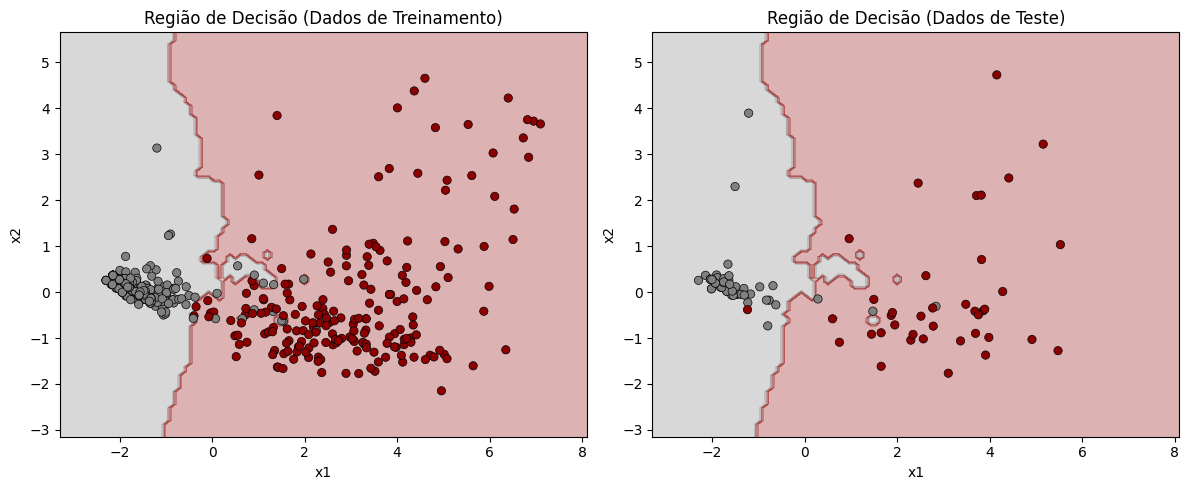

In [57]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(12)

# **Gráfico para os dados de treinamento**
DecisionBoundaryDisplay.from_estimator(
    best_knn_pca,
    X_train_pca,
    response_method="predict",
    cmap=ListedColormap([custom_palette[0], custom_palette[1]]),
    alpha=0.3,
    ax=ax1,
)

sns.scatterplot(
    x=X_train_pca[:, 0],
    y=X_train_pca[:, 1],
    hue=y_train,
    palette=custom_palette,
    ax=ax1,
    edgecolor='k',
    legend=False
)

ax1.set_title("Região de Decisão (Dados de Treinamento)")
ax1.set_xlabel("x1")
ax1.set_ylabel("x2")

# **Gráfico para os dados de teste**
DecisionBoundaryDisplay.from_estimator(
    best_knn_pca,
    X_train_pca,
    response_method="predict",
    cmap=ListedColormap([custom_palette[0], custom_palette[1]]),
    alpha=0.3,
    ax=ax2,
)

sns.scatterplot(
    x=X_test_pca[:, 0],
    y=X_test_pca[:, 1],
    hue=y_test,
    palette=custom_palette,
    ax=ax2,
    edgecolor='k',
    legend=False
)

ax2.set_title("Região de Decisão (Dados de Teste)")
ax2.set_xlabel("x1")
ax2.set_ylabel("x2")

plt.tight_layout()
plt.show()

## Retreinando melhor modelo

In [58]:
best_knn = KNeighborsClassifier(n_neighbors=best_k, weights='distance')
best_knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=7, weights='distance')

## Análise da performance do melhor modelo nos dados de test

In [59]:
y_pred = best_knn.predict(X_test)

### Relatório de classificação (Precision, Recall, F1-Score para cada classe)

#### Precisão:
Fração de previsões corretas para a classe positiva:
$$
\text{Precisão} = \frac{\text{VP}}{\text{VP} + \text{FP}}
$$

#### Sensibilidade ou revocação:
Fração de exemplos positivos corretamente identificados:
$$
\text{Revocação} = \frac{\text{VP}}{\text{VP} + \text{FN}}
$$

#### F1-Score:
Média harmônica entre Precisão e Revocação:
$$
\text{F1-Score} = 2 \cdot \frac{\text{Precisão} \cdot \text{Revocação}}{\text{Precisão} + \text{Revocação}}
$$


In [60]:
class_report = classification_report(y_test, y_pred)
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=["Benigno", "Maligno"]))

Relatório de Classificação:
              precision    recall  f1-score   support

     Benigno       0.98      0.97      0.98        66
     Maligno       0.95      0.97      0.96        39

    accuracy                           0.97       105
   macro avg       0.97      0.97      0.97       105
weighted avg       0.97      0.97      0.97       105



### Matriz confusão

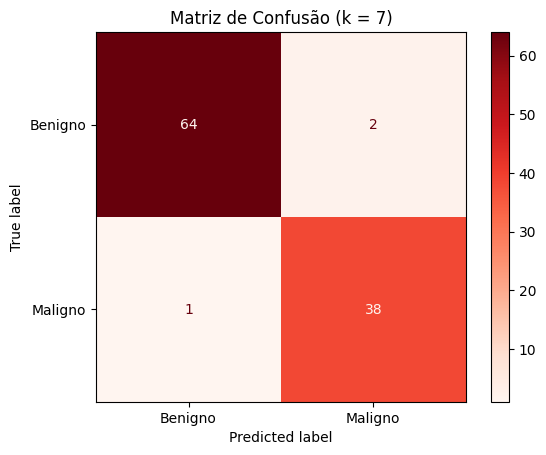

In [61]:
conf_matrix = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Benigno", "Maligno"])
disp.plot(cmap="Reds", values_format='d')
plt.title(f"Matriz de Confusão (k = {best_k})")
plt.show()

### ROC-AUC Score e curva ROC

ROC-AUC Score: Mede a separabilidade das classes com base nas probabilidades previstas. Um AUC de 1 indica classificação perfeita.

Curva ROC: Mostra a relação entre True Positive Rate (TPR) e False Positive Rate (FPR) para diferentes limiares.

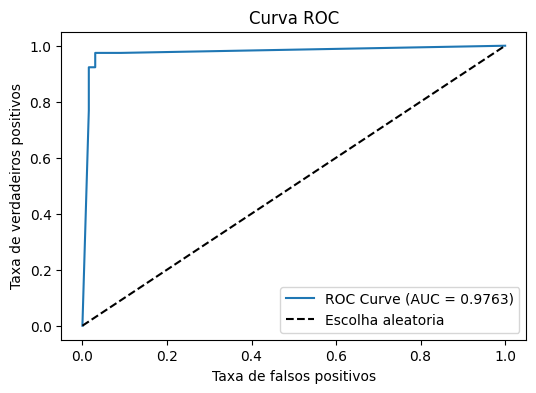

In [62]:
y_pred_proba = best_knn.predict_proba(X_test)[:, 1]  # Probabilidades da classe positiva
roc_auc = roc_auc_score(y_test, y_pred_proba)

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Escolha aleatoria")
plt.xlabel("Taxa de falsos positivos")
plt.ylabel("Taxa de verdadeiros positivos")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.show()


Concluímos que nosso modelo conseguiu prever a classificação de tumores benignos e malignos.